In [1]:
import os
import sys
import copy

import matplotlib.pyplot as plt
import numpy as np

import anotherpipe.powerestimation.powerestimate as pe

from pypower import PowerSpectrumSmoothWindowMatrix

sys.path.append('../bin')
from sculpt_window import get_data, SculptWindow
from window import WindowRotation
from utils import load_poles
from local_file_manager import LocalFileName
from desi_file_manager import DESIFileName

plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plt.rcParams["figure.autolayout"] = False
plots_dir = '../../plots/'

In [2]:
source = 'desi'
mockgen = 'second'
version = 'v4_1'

tracer = "ELG_LOPnotqso"
region = "SGC"
zrange = (1.1, 1.6)
completeness = True

ells = [0, 2, 4]

kolim = (0., 0.4)
korebin = 5
ktmax = 0.5
ktrebin = 1

rpcut = 0.
thetacut = 0.05

capsigW = 5
capsigR = 2
difflfac = 10
csub = True
covtype = 'ezmocks'

## Input & transformed $P(k)$, $W(k, k^{\prime})$, $C$

In [4]:
data_dir = "/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/{}/sculpt_window".format(version)

sculptwm_fn = LocalFileName().set_default_config(ftype='rotated_all', tracer=tracer, region=region, completeness=completeness, realization=None, rpcut=rpcut, thetacut=thetacut)
sculptwm_fn.rotation_attrs['ells'] = ells
sculptwm_fn.rotation_attrs['kobsmax'] = kolim[-1]
sculptwm_fn.rotation_attrs['ktmax'] = ktmax
sculptwm_fn.rotation_attrs['max_sigma_W'] = capsigW
sculptwm_fn.rotation_attrs['max_sigma_R'] = capsigR
sculptwm_fn.rotation_attrs['factor_diff_ell'] = difflfac
sculptwm_fn.rotation_attrs['covtype'] = covtype
sculptwm_fn.rotation_attrs['csub'] = csub
sculptwm_fn.update(fdir=data_dir, zrange=zrange, cellsize=None, boxsize=None, directedges=False)
sculptwm = SculptWindow.load(sculptwm_fn.get_path())

wm = sculptwm.wmatrix
pk = sculptwm.pk
cov = sculptwm.cov

wmnew = sculptwm.wmatrixnew
pknew = sculptwm.pknew
mmatrix = sculptwm.mmatrix
mo = sculptwm.mo

In [5]:
data_nocut = get_data(source=source, catalog=mockgen, version=version, tracer=tracer, region=region, completeness=completeness, rpcut=0, thetacut=0, zrange=zrange, kolim=kolim, korebin=korebin, ktmax=ktmax, ktrebin=ktrebin, covtype=covtype)
wm_nocut = data_nocut['wmatrix']

wmnew_nocut = wmnew.copy()
wmnew_nocut.value = np.matmul(mmatrix, wm.value.T - wm_nocut.value.T).T

/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1/complete/2pt/merged/pk/wmatrix_smooth_ELG_LOP_SGC_z1.1-1.6_default_FKP_lin_nran18_cellsize6_boxsize9000.npy
/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_gaussian_pre_ELG_LOPnotqso_SGC_1.1_1.6_default_FKP_lin.txt
/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_SGC_z1.100-1.600_k0.00-0.40.npy
Loading EZmocks covariance: /global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_SGC_z1.100-1.600_k0.00-0.40.npy


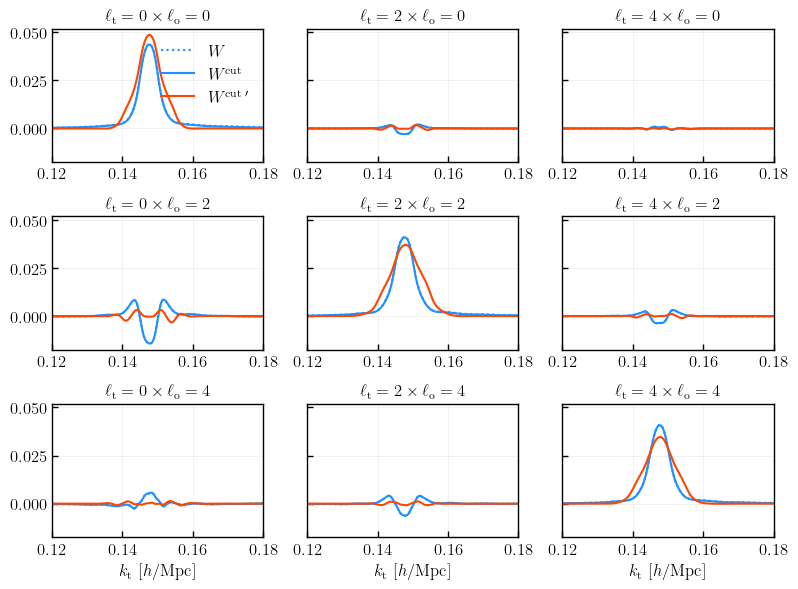

In [6]:
kobs = [0.15]
alphas = [1.]

fig, lax = plt.subplots(len(ells), len(ells), sharey=True, figsize=(8, 6))

for i in range(len(kobs)):
    indexout = np.abs(wm.xout[0] - kobs[i]).argmin()
    
    for iin, projin in enumerate(ells):
        for iout, projout in enumerate(ells):
            ax = lax[iout][iin]
            # Indices in approximative window matrix
            norm = 1. #np.max(np.abs(wm.unpacked()[iin][iout][:, indexout] / wm.xin[iin]))
            ax.plot(wm_nocut.xin[iin], wm_nocut.unpacked()[iin][iout][:, indexout]/norm, label=r'$W$' if i==len(kobs)-1 else '', color='C0', ls=':', alpha=alphas[i])
            ax.plot(wm.xin[iin], wm.unpacked()[iin][iout][:, indexout]/norm, label=r'$W^{\mathrm{cut}}$' if i==len(kobs)-1 else '', color='C0', alpha=alphas[i])
            ax.plot(wmnew.xin[iin], wmnew.unpacked()[iin][iout][:, indexout]/norm, label=r'$W^{\mathrm{cut} \; \prime}$' if i==len(kobs)-1 else '', color='C1', alpha=alphas[i])
            #text = r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(projin, projout)
            #ax.text(0.05, 0.95, text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black')
            ax.set_title(r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(projin, projout))
            ax.set_xlim((0.12, 0.18))
            if iout == len(ells) - 1: ax.set_xlabel(r'$k_{\mathrm{t}}$ [$h/\mathrm{Mpc}$]')
            if i==len(kobs)-1 and iin == iout == 0: lax[iout][iin].legend()

plt.subplots_adjust(wspace=0.1, hspace=0.12)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, version, 'sculptedwindow_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_capsigW{}_capsigR{}_difflfac{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else '')), dpi=300)
plt.show()

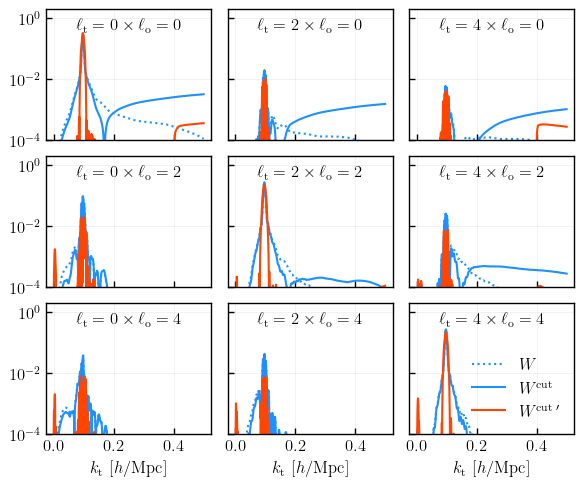

In [7]:
kouts = [0.1]
alphas = np.linspace(1, 0.2, len(kouts))

plt.rcParams["figure.autolayout"] = False

fig, lax = plt.subplots(len(ells), len(ells), sharex=True, sharey=True, figsize=(6, 5))

for iin, projin in enumerate(ells):
    for iout, projout in enumerate(ells):
        ax = lax[iout][iin]

        for ki, kout in enumerate(kouts):
            indexout = np.abs(wm.xout[0] - kout).argmin()
            # Indices in approximative window matrix
            norm = 1 #np.max(np.abs(wm.unpacked()[iin][iout][:, indexout] / wm.xin[iin]))
            ax.semilogy(wm_nocut.xin[iin], np.abs(wm_nocut.unpacked()[iin][iout][:, indexout]/norm/wm_nocut.xin[iin]), alpha=alphas[ki], color='C0', ls=':', label=r'$W$' if ki==0 else '')
            ax.semilogy(wm.xin[iin], np.abs(wm.unpacked()[iin][iout][:, indexout]/norm/wm.xin[iin]), alpha=alphas[ki], color='C0', label=r'$W^{\mathrm{cut}}$' if ki==0 else '')
            ax.semilogy(wmnew.xin[iin], np.abs(wmnew.unpacked()[iin][iout][:, indexout]/norm/wmnew.xin[iin]), alpha=alphas[ki], color='C1', label=r'$W^{\mathrm{cut} \; \prime}$' if ki==0 else '')
        text = r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(projin, projout)
        xlim = ax.get_xlim()
        ax.text((xlim[0]+xlim[1])/2., 1., text, horizontalalignment='center', verticalalignment='top', color='black', fontsize=12)
        #ax.set_title(r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(projin, projout))
        ax.set_ylim((1e-4, 2))
        if iout == len(ells) - 1: ax.set_xlabel(r'$k_{\mathrm{t}}$ [$h/\mathrm{Mpc}$]')
        if (iin == 2) & (iout == 2): lax[iout][iin].legend(loc='lower right')
        
plt.subplots_adjust(wspace=0.1, hspace=0.12)
#plt.tight_layout()
plt.savefig(os.path.join(plots_dir, version, 'sculptedwindow_semilogy_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_capsigW{}_capsigR{}_difflfac{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else '')), dpi=300)
plt.show()

### Quantify gain in compactness of the window

In [8]:
def compacity(wmatrix, ells=[0, 2, 4], alpha=0.95):
    w = wmatrix.deepcopy()
    if len(ells)==1:
        w.select_proj(projsout=(0, None))
    else:
        w.select_proj(projsout=[(ell, None) for ell in ells])
    # split in multipoles
    wsplit = np.array_split(w.value, 3, axis=0)
    kin = w.xin[0]
    weights_bf = np.sum(np.array([np.cumsum(np.abs(wsplit[i]), axis=0) for i in range(len(ells))]), axis=0)
    weight_bf = np.sum(np.array_split(weights_bf, len(ells), axis=-1), axis=0)
    weights_tot = np.sum(np.array([np.sum(np.abs(wsplit[i]), axis=0) for i in range(len(ells))]), axis=0)
    weight_tot = np.sum(np.array_split(weights_tot, len(ells), axis=-1), axis=0)
    r = weight_bf / weight_tot
    iktmax = np.argmax(r >= alpha, axis=0)
    return kin[iktmax]

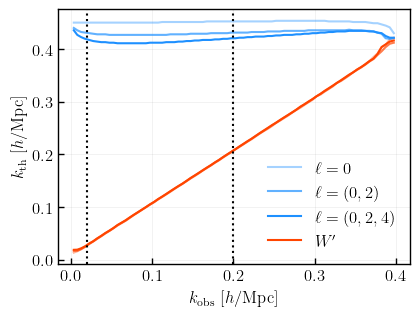

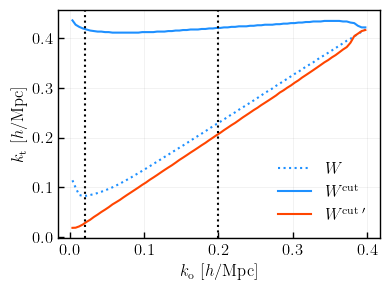

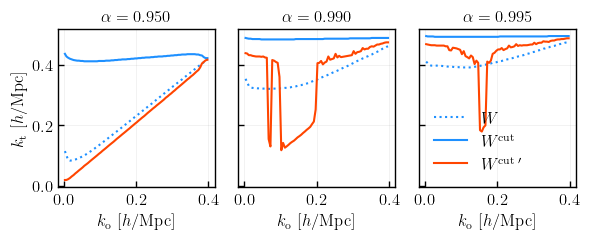

In [9]:
alpha = 0.95
ells = [0, 2, 4]

plt.figure(figsize=(4, 3))
plt.plot(wm.xout[0], compacity(wm, ells=[0], alpha=alpha), color='C0', alpha=0.4, label=r'$\ell = 0$')
plt.plot(wmnew.xout[0], compacity(wmnew, ells=[0], alpha=alpha), color='C1', alpha=0.4)

plt.plot(wm.xout[0], compacity(wm, ells=[0, 2], alpha=alpha), color='C0', alpha=0.7, label=r'$\ell = (0, 2)$')
plt.plot(wmnew.xout[0], compacity(wmnew, ells=[0, 2], alpha=alpha), color='C1', alpha=0.7)

plt.plot(wm.xout[0], compacity(wm, ells=ells, alpha=alpha), label=r'$\ell = (0, 2, 4)$', color='C0')
plt.plot(wmnew.xout[0], compacity(wmnew, ells=ells, alpha=alpha), label=r'$W^{\prime}$', color='C1')

plt.axvline(0.02, ls=':', color='black')
plt.axvline(0.2, ls=':', color='black')

plt.xlabel(r'$k_{\mathrm{obs}}$ [$h$/Mpc]')
plt.ylabel(r'$k_{{\mathrm{{th}}}}$ [$h$/Mpc]'.format(alpha))
plt.legend()
#plt.savefig(os.path.join(plots_dir, version, 'compacity_0.95_{}_complete_{}_{}_{}_{}cut{:.2f}_capsig{}_difflfac{}_{}cov.pdf'.format(tracer, region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), capsig, difflfac, covtype)), dpi=100)
plt.show()


plt.figure(figsize=(4, 3))
plt.plot(wm_nocut.xout[0], compacity(wm_nocut, ells=ells, alpha=alpha), color='C0', ls=':')
plt.plot(wm.xout[0], compacity(wm, ells=ells, alpha=alpha), color='C0')
plt.plot(wmnew.xout[0], compacity(wmnew, ells=ells, alpha=alpha), color='C1')

plt.axvline(0.02, ls=':', color='black')
plt.axvline(0.2, ls=':', color='black')

plt.xlabel(r'$k_{\mathrm{o}}$ [$h$/Mpc]')
plt.ylabel(r'$k_{{\mathrm{{t}}}}$ [$h$/Mpc]'.format(alpha))
plt.plot([], [], color='C0', ls=':', label=r'$W$')
plt.plot([], [], color='C0', label=r'$W^{\mathrm{cut}}$')
plt.plot([], [], color='C1', label=r'$W^{\mathrm{cut} \; \prime}$')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, version, 'compacity_0.95_{}_{}_{}_{}_{}_{}cut{:.2f}_capsigW{}_capsigR{}_difflfac{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), capsigW, capsigR, difflfac, covtype, '_csub' if csub else '')), dpi=100)
plt.show()


fig, axes = plt.subplots(1, 3, sharey=True, figsize=(6, 2.5))

for i, alpha in enumerate([0.95, 0.99, 0.995]):
    axes[i].plot(wm_nocut.xout[0], compacity(wm_nocut, ells=ells, alpha=alpha), color='C0', ls=':')
    axes[i].plot(wm.xout[0], compacity(wm, ells=ells, alpha=alpha), color='C0')
    axes[i].plot(wmnew.xout[0], compacity(wmnew, ells=ells, alpha=alpha), color='C1')
    axes[i].set_xlabel(r'$k_{\mathrm{o}}$ [$h$/Mpc]')
    axes[i].set_title(r'$\alpha = {:.3f}$'.format(alpha))
axes[2].plot([], [], color='C0', ls=':', label=r'$W$')
axes[2].plot([], [], color='C0', label=r'$W^{\mathrm{cut}}$')
axes[2].plot([], [], color='C1', label=r'$W^{\mathrm{cut} \; \prime}$')
axes[0].set_ylabel(r'$k_{{\mathrm{{t}}}}$ [$h$/Mpc]'.format(alpha))
axes[2].legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, version, 'compacity_{}_{}_{}_{}_{}_{}cut{:.2f}_capsigW{}_capsigR{}_difflfac{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), capsigW, capsigR, difflfac, covtype, '_csub' if csub else '')), dpi=100)
plt.show()

### Transformed $P(k)$

In [10]:
pk_fn = DESIFileName()
pk_fn.set_default_config(version=version, tracer=tracer, region=region, completeness=completeness)

from utils import load_poles_list
pk = load_poles_list([pk_fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut, zrange=zrange) for imock in range(25)], xlim={ell: (kolim[0], kolim[1], 0.005) for ell in ells})
pknew = mmatrix.dot(pk['data'].flatten())

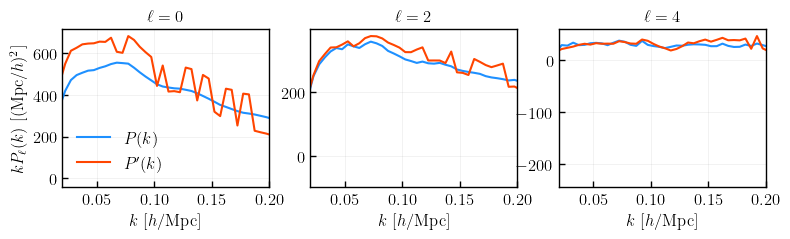

In [11]:
fig, axes = plt.subplots(1, len(ells), figsize=(8, 2.5), sharey=False)

for i, ell in enumerate(ells):
    axes[i].plot(wm.xout[i], wm.xout[i] * pk['data'][i], color='C0', label=r'$P(k)$')
    axes[i].plot(wmnew.xout[i], wmnew.xout[i] * pknew.reshape((len(ells), len(wmnew.xout[i])))[i], color='C1', label=r'$P^{\prime}(k)$')
    axes[i].set_title(r'$\ell={}$'.format(ell))
    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')
    axes[i].set_xlim((0.02, 0.2))

axes[0].legend()
axes[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(plots_dir, version, 'sculptedwindow_pknew_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_capsigW{}_capsigR{}_difflfac{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else '')), dpi=300)
plt.show()

### Transformed covariance matrix

In [12]:
covnew = sculptwm.covnew

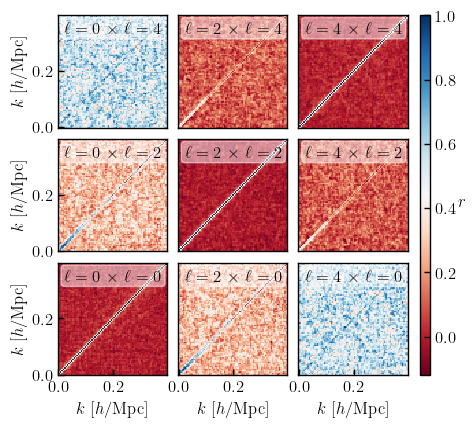

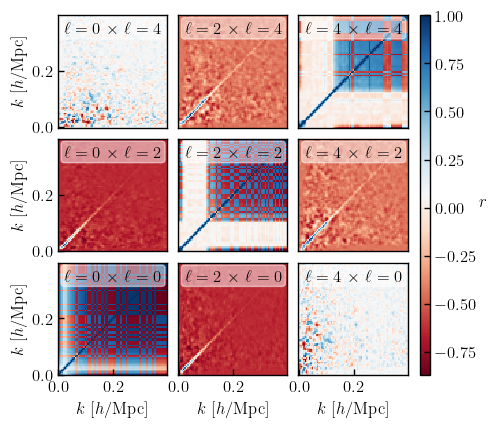

In [13]:
from cov_utils import plot_corrcoef

from matplotlib import colors
norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

cov_fn = os.path.join(plots_dir, version, 'cov_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.png'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))
covnew_fn = os.path.join(plots_dir, version, 'rotatedcov_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.png'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))

plot_corrcoef(cov, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.savefig(cov_fn, dpi=300)
plt.show()

plot_corrcoef(covnew, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.savefig(covnew_fn, dpi=300)
plt.show()

### EZmocks covariance obtained with M from analytic covariance

In [14]:
cov_ezmocks = get_data(source=source, catalog=mockgen, version=version, tracer=tracer, region=region, rpcut=0, thetacut=0.05, zrange=zrange, kolim=kolim, korebin=korebin, ktmax=ktmax, ktrebin=ktrebin, covtype='ezmocks')['covariance']

/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1/complete/2pt/merged/pk/wmatrix_smooth_ELG_LOP_SGC_z1.1-1.6_default_FKP_lin_nran18_cellsize6_boxsize9000_thetacut0.05.npy
/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_gaussian_pre_ELG_LOPnotqso_SGC_1.1_1.6_default_FKP_lin.txt
/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_SGC_z1.100-1.600_k0.00-0.40_thetacut0.05.npy
Loading EZmocks covariance: /global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_SGC_z1.100-1.600_k0.00-0.40_thetacut0.05.npy


In [15]:
covnew_ezmocks = np.matmul(np.matmul(mmatrix, cov_ezmocks), mmatrix.T) #- np.sum(np.array([np.array(sculptwm.m)[i] * np.outer(mo[i], mo[i]) for i in range(len(ells))]), axis=0)

In [ ]:
ezmocks_cov_fn = os.path.join(plots_dir, version, 'ezmocks_cov_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.png'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))
ezmocks_covnew_fn = os.path.join(plots_dir, version, 'rotated_ezmocks_cov_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.png'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))

plot_corrcoef(cov_ezmocks, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.savefig(ezmocks_cov_fn, dpi=300)
plt.show()

plot_corrcoef(covnew_ezmocks, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.savefig(ezmocks_covnew_fn, dpi=300)
plt.show()